# Initial State Dispersion to improve the exercise Strategy
We start with the exented example, and we add an itinital state dispersion to improve the exercise bondary

For now, we will not price the option.

To price the option with an initial state dispersion, we either need to proceed in two steps: 1- Approximate all the betas for the optimal stopping time, and then apply them to a new simulation that does not have an ISD, or 2- Apply another technique that has not been covered yet. We will do this in another example.


In [36]:
# Set the initial variables for the script
import numpy as np

# Define parameters
r = 0.06    # Interest rate
K = 1.00    # Strike price
# it is better to work in time-steps than in years
dt = 1/12   # Time-step size in years
nt = 12     # Number of time-steps
T = nt*dt   # Total time to maturity in years

N = 10000      # Number of simulations
M = 9          # polynomial order for cross-sectional regressions

# For the stock price, here, we will simulate from a Geometric Brownian motion
# We assume a risk-neutral measure
S0 = 1.00   # Initial stock price
sigma = 0.2  # Volatility of the stock

# Set the random seed for reproducibility
# We use numpy's SeedSequence to create a reproducible random number generator
SEED = 42  # Seed for reproducibility
SEQ = np.random.SeedSequence(SEED)
SeedSeq = SEQ.spawn(1)
My_Stream = np.random.default_rng(SeedSeq[0])

# It is possible to simulate from a Geometric Brownian motion without using a loop
# How ever, for clarity, we will use a loop here
S = np.zeros((N, nt + 1))
S[:, 0] = np.linspace(0.1, 2, N)
for i in range(1, nt + 1):
    Z = My_Stream.normal(0, 1, N)  # Standard normal random variables
    S[:, i] = S[:, i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    

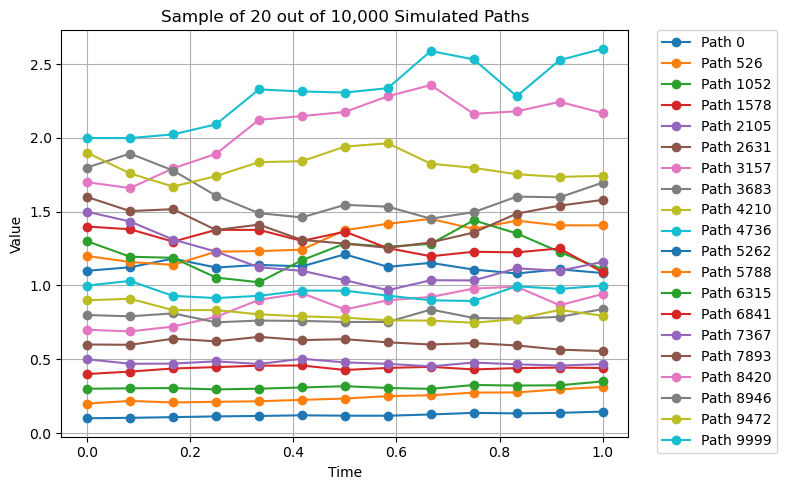

In [37]:
import matplotlib.pyplot as plt

sample_size = 20  # Number of paths to plot
# We want a good representation of the paths, so we will sample 1 path every sample_size
sample_indices = np.linspace(0, N-1, sample_size, dtype=int)

# check if sample_size is less than N
if sample_size > N:
    raise ValueError("sample_size must be less than or equal to N")

# Now plot the simulated paths if we want too
times = np.linspace(0, T, nt + 1)

plt.figure(figsize=(8, 5))
for i in range(sample_size):
    plt.plot(times, S[sample_indices[i]], marker='o', label=f'Path {sample_indices[i]}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Sample of {sample_size} out of {N:,} Simulated Paths')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

In [38]:
# Initiate the backward algorithm and calculate the option payoff (exercise/intrinsic value), conditional on not exercising prior

# We will calculate the exercise/intrinsic value for each path at maturity
# recall that the option to price is a put option
intrinsic = np.maximum(K - S[:,-1], 0)

# We create a payoff vector that will contain the discounted exercise value.
payoff = np.copy(intrinsic)

# Now we set the vector exec_t to maturity for each path
exec_t = nt * np.ones((N,), dtype=int)  # All paths would optimally be exercised at time-step 3 (so far))

# Now, we can start the backward algorithm at t=nt-1, and loop all the way back to t=1

# STEP 1	Discount the cash flows to time "t" based on when it's optimal to exercise for each path
# STEP 2	Identify the ITM paths in order toregress only on ITM paths
# STEP 3	Build X matrix for regression
# STEP 4	build y vector
# STEP 5	regress to get beta
# STEP 6	Calculate y_hat to approximate the holding value function
# STEP 7	Update the optimal exercise time for each path

# We will do one more thing, for illustration purposes, we will keep the beta coefficients for each time-step in a matrix
betas = np.zeros((M+1, nt))  # Store beta coefficients for each time-step


for t_now in range(nt-1, 0, -1):

    # STEP 1
    dcf = np.exp(-r * dt) * payoff  # Discounted cash flow to time t

    # STEP 2
    itm_paths = np.where(S[:, t_now] < K)[0]  # Identify ITM paths

    # STEP 3
    # Build X matrix for regression (using the stock prices at time t_now)
    # We use a constant, the stock price and the square of the stock price
    # Build X matrix for a polynomial of order 9 using Horner's method
    x = S[itm_paths, t_now]
    X = np.ones((len(itm_paths), M + 1))
    for j in range(1, M + 1):
        X[:, j] = X[:, j - 1] * x

    # STEP 4
    # Build y vector (the discounted cash flows for ITM paths)
    y = dcf[itm_paths]

    # STEP 5
    # Perform regression to get beta coefficients
    from numpy.linalg import lstsq
    beta = lstsq(X, y, rcond=None)[0]
    # Store the beta coefficients for this time-step
    betas[:,t_now] = beta

    # """
    # DEBUG
    # """
    # if t_now == nt - 1:
    #     # print top 5 lines of matrix X and y
    #     print("DEBUG: X matrix (first 5 rows):")
    #     print(X[:5])
    #     print("DEBUG: y vector (first 5 values):")
    #     print(y[:5])
    #     print("DEBUG: beta coefficients:")
    #     print(beta)
    #     break

    # STEP 6
    # Calculate y_hat to approximate the holding value function
    y_hat = X @ beta

    # Update the payoff for exercised paths to be the current intrinsic value
    intrinsic[itm_paths] = np.maximum(K - S[itm_paths, t_now], 0)

    # STEP 7
    # Update the optimal exercise time for each path
    exec_t[itm_paths] = np.where(y_hat < intrinsic[itm_paths], t_now, exec_t[itm_paths])
    payoff = np.where(exec_t == t_now, intrinsic, dcf)

print(betas.transpose())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 9.19300970e-01  1.32485629e+00 -2.90445791e+01  1.93330052e+02
  -7.57143358e+02  1.82054807e+03 -2.70997610e+03  2.42957380e+03
  -1.20068309e+03  2.51210601e+02]
 [ 1.27767405e+00 -9.11797468e+00  9.48068028e+01 -5.94970823e+02
   2.22911684e+03 -5.20885413e+03  7.64155640e+03 -6.82676893e+03
   3.38775428e+03 -7.14739865e+02]
 [ 1.20815767e+00 -7.36558922e+00  7.75557625e+01 -5.06671074e+02
   1.96790252e+03 -4.74690496e+03  7.16196966e+03 -6.55992368e+03
   3.32910001e+03 -7.16832183e+02]
 [ 1.10952616e+00 -4.41037520e+00  4.13348449e+01 -2.67936804e+02
   1.02764143e+03 -2.43700551e+03  3.60383839e+03 -3.22957973e+03
   1.60194758e+03 -3.36885256e+02]
 [ 1.01920576e+00 -1.59605252e+00  5.38059640e+00 -2.26438396e+01
   4.48820839e+01 -2.54984255e+01 -5.29622022e+01  1.05683874e+02
  -7.23925476e+01  1.81697489e+01

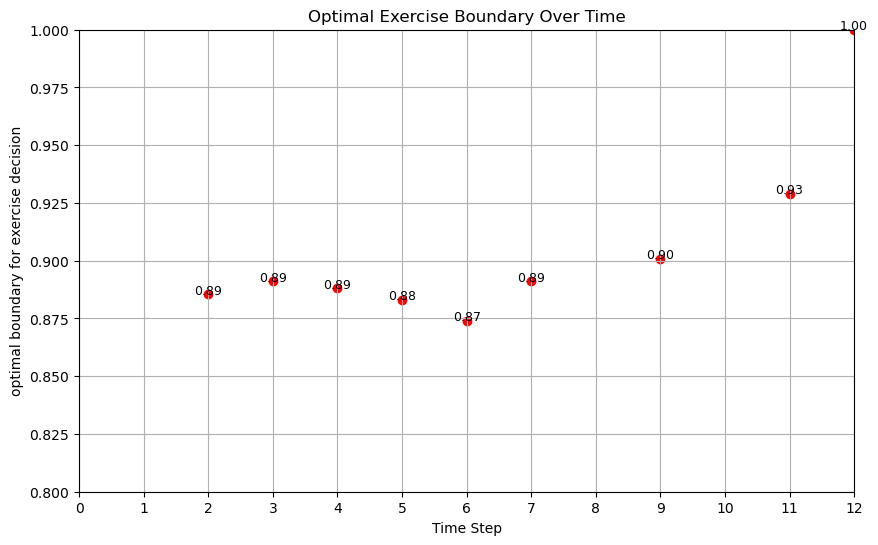

In [39]:
# Now, I want to loop through the betas and locate the intersection of the polynomial with the exercise value
# This will give use the optimal exercise boundary for this option

# For each time-step, beta defines a polynomial or second degree.
# The exercise value is polynomial of degree 1, so we can find the intersection points
import numpy.polynomial.polynomial as P
# Define the exercise value polynomial coefficients
exercise_value_coeffs = [K, -1]  # Coefficients for the line y = K - x

# We will keep the intersection points for each time-step
intersection_points = []

# Loop through the betas and find the intersection points
for t in range(1, nt):
    # Get the beta coefficients for this time-step
    beta = betas[:, t]
    # print(f"\nTime-Step {t} Beta Coefficients:\n", np.array2string(beta, formatter={'float_kind':lambda x: f"{x:.4f}"}))

    # Define the polynomial for the option value
    option_value_poly = P.Polynomial(beta)
    option_execs_poly = P.Polynomial(exercise_value_coeffs)  # Second degree polynomial for the option value

    intersection = P.polyroots((option_value_poly - option_execs_poly).coef)
    # print(f"Intersection Points for Time-Step {t}:\n", np.array2string(intersection, formatter={'float_kind':lambda x: f"{x:.4f}"}))

    # I will only keep the intersection points where the x-coordinate is less than or equal to K
    intersection = intersection[intersection.real <= K]
    # If there are two intersection points, we will keep the one that is closest to K
    if len(intersection) > 1:
        intersection = intersection[np.abs(intersection - K).argmin()]
    elif len(intersection) == 0:
        intersection = np.array([])

    # Keep only the real roots
    intersection = intersection[intersection.imag == 0].real

    intersection_points.append(intersection)

# We know the optimal exercise at nt is at K, so we will append it to the intersection points
intersection_points.append(np.array([K]))

# Collect all valid intersection points and their time steps
x_vals = []
y_vals = []
for t, intersection in enumerate(intersection_points, start=1):
    if intersection.size > 0:
        x_vals.append(t)
        y_vals.append(intersection[0])

plt.figure(figsize=(10, 6))
plt.scatter(x_vals, y_vals, color='red')
for t, y in zip(x_vals, y_vals):
    plt.text(t, y, f"{y:.2f}", fontsize=9, ha='center')
plt.ylim(0.8, 1)
plt.xlim(0, nt)
plt.xticks(np.arange(0, nt + 1, 1))
plt.xlabel('Time Step')
plt.ylabel('optimal boundary for exercise decision')
plt.title('Optimal Exercise Boundary Over Time')
plt.grid(True)
plt.show()

This exercise boundary is NOT better. The reason is probably due to the number of paths